In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import InputLayer
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy, AUC
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D



Using TensorFlow backend.


In [2]:
# Add an additional column, mapping to the type
df = pd.read_csv('../input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


In [3]:
df.columns

Index(['id_code', 'diagnosis', 'binary_type', 'type'], dtype='object')

In [4]:
df['type'].value_counts()

No_DR             1805
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: type, dtype: int64

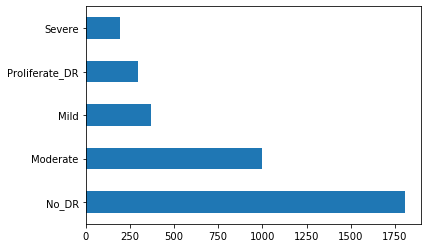

In [5]:
df['type'].value_counts().plot(kind='barh')

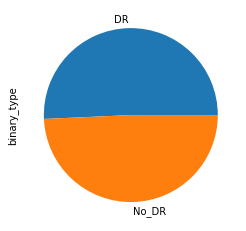

In [6]:
df['binary_type'].value_counts().plot(kind='pie')

In [7]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print("Train")
print(train['type'].value_counts(), '\n')
print("Valid")
print(val['type'].value_counts(), '\n')
print("Test")
print(test['type'].value_counts(), '\n')

Train
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: type, dtype: int64 

Valid
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 

Test
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 



In [8]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [9]:
# Copy images to respective working directory
src_dir = '../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)


In [10]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

# pixel is smallest element in image...contains color infos...RGB na grayscale mode values
# RGB mode image value point ranges from 0 to 255...so, rescaled them to 0 to 1 value by dividing by 1/255
# rescaling is a simple form of data normalization or preprocessing

Found 2562 images belonging to 5 classes.
Found 550 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


In [11]:
os.listdir('/kaggle/working/train')

['Proliferate_DR', 'Mild', 'Moderate', 'No_DR', 'Severe']

# CNN Model

In [12]:
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), padding="same", input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),

    layers.Conv2D(64, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),

    layers.Conv2D(128, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # Adjust the number of classes

])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adjust learning rate
              loss='categorical_crossentropy',  # Use categorical cross-entropy for classification
              metrics=['accuracy'])  # Use 'accuracy' as a metric

history = model.fit(train_batches, epochs=20, validation_data=val_batches, verbose=1)


Train for 81 steps, validate for 18 steps
Epoch 1/20
81/81 [==============================] - 14s 170ms/step - loss: 1.0104 - accuracy: 0.6440 - val_loss: 1.3175 - val_accuracy: 0.4109
Epoch 2/20
81/81 [==============================] - 10s 124ms/step - loss: 0.7907 - accuracy: 0.7143 - val_loss: 1.4967 - val_accuracy: 0.2727
Epoch 3/20
81/81 [==============================] - 10s 125ms/step - loss: 0.7664 - accuracy: 0.7240 - val_loss: 1.8640 - val_accuracy: 0.2727
Epoch 4/20
81/81 [==============================] - 10s 128ms/step - loss: 0.7087 - accuracy: 0.7412 - val_loss: 2.1803 - val_accuracy: 0.2691
Epoch 5/20
81/81 [==============================] - 10s 123ms/step - loss: 0.6920 - accuracy: 0.7412 - val_loss: 1.8341 - val_accuracy: 0.2745
Epoch 6/20
81/81 [==============================] - 10s 122ms/step - loss: 0.6357 - accuracy: 0.7576 - val_loss: 1.5500 - val_accuracy: 0.2255
Epoch 7/20
81/81 [==============================] - 10s 125ms/step - loss: 0.6158 - accuracy: 0.7623

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      2

In [14]:
print(test_batches)

In [15]:
loss = model.evaluate(test_batches, verbose=1)
print("LOSS: ", loss)

18/18 [==============================] - 2s 96ms/step - loss: 1.7956 - accuracy: 0.5655
LOSS:  [1.7955501824617386, 0.56545454]


In [16]:
history.history

{'loss': [1.0206941834227077,
  0.798362055123085,
  0.7750932620583825,
  0.7145676260041968,
  0.6977186432743705,
  0.6424570922782699,
  0.6220965872487456,
  0.583325796847135,
  0.5520511074842279,
  0.5036742904054105,
  0.47039409235387364,
  0.41128680282137897,
  0.3579147891196001,
  0.32276571454054254,
  0.2651280718117627,
  0.2382079863660532,
  0.2034715880893584,
  0.17303933492650123,
  0.25753765523573274,
  0.2470958854230288],
 'accuracy': [0.6440281,
  0.71428573,
  0.7240437,
  0.7412178,
  0.7412178,
  0.7576112,
  0.76229507,
  0.7849336,
  0.7907885,
  0.81459796,
  0.8196721,
  0.84738487,
  0.8657299,
  0.8840749,
  0.91686183,
  0.92076504,
  0.93325526,
  0.94028103,
  0.90398127,
  0.913349],
 'val_loss': [1.3175366587109036,
  1.4966529144181147,
  1.8639669683244493,
  2.1803207529915705,
  1.83409935898251,
  1.5499936872058444,
  2.5409407880571155,
  2.3328004015816584,
  2.9338013463550143,
  1.1746982832749684,
  0.9592879845036401,
  1.84098316563

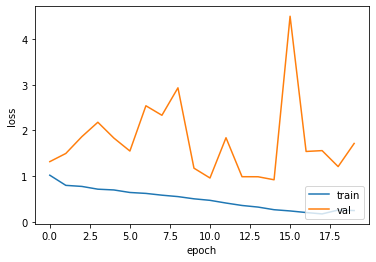

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')


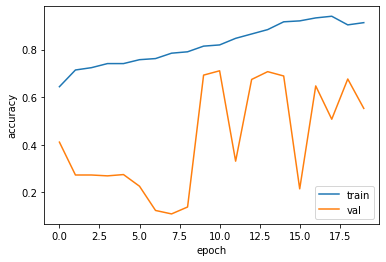

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')


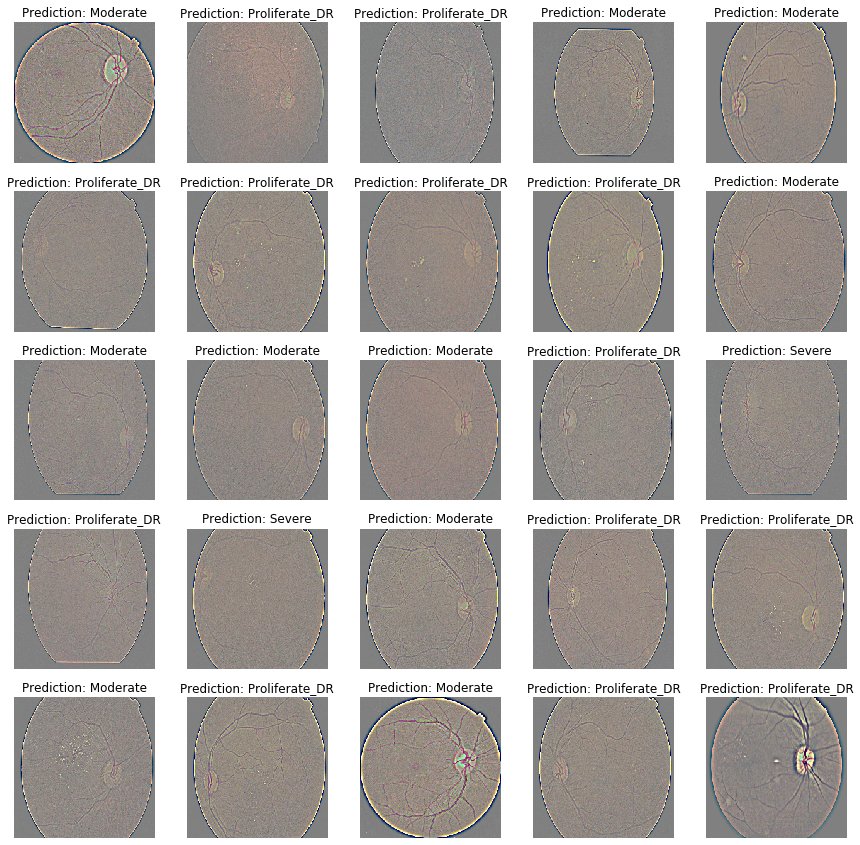

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Assuming 'test_batches' is an instance of ImageDataGenerator.flow_from_directory for the test dataset

# Get predictions
pred = model.predict(test_batches)
pred = np.argmax(pred, axis=1)

# Map the label
labels = train_batches.class_indices
labels = dict((v, k) for k, v in labels.items())
pred_labels = [labels[k] for k in pred]

# Display the result along with images
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    # Load and display the image
    img_path = test_batches.filepaths[i + 25]  # Adjust the index as needed
    img = image.load_img(img_path, target_size=(224, 224))  # Adjust the target size as needed
    ax.imshow(img)
    ax.axis('off')

    # Display the prediction
    ax.set_title(f'Prediction: {pred_labels[i]}')

plt.show()


In [20]:
print(f'The first 100 predictions: {pred[:5]}')

The first 100 predictions: ['Moderate', 'Proliferate_DR', 'Proliferate_DR', 'Moderate', 'Moderate']


In [21]:
print(f'The first 100 predictions: {pred[24:25]}')


The first 100 predictions: ['Proliferate_DR']
